# Functional Connectivity Length Test

### Import modules

In [21]:
## import libraries 
import os
from pathlib import Path
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
import seaborn as sns 
from scipy.stats import ttest_ind
import networkx as nx

In [2]:
## define path variables 
DATA_PATH = "/Users/praveslamichhane/Desktop/alzheimers/data/1CLT" ## path to where the data is mounted

### Load data

In [3]:
dF_F = np.load(os.path.join(DATA_PATH, "dF_F.npy")) ## load the dF_F data

### Define Global Variables

In [4]:
## set global variables
NUM_CELLS = dF_F.shape[0]
NUM_POINTS = dF_F.shape[1]
FRAME_RATE = 15.49 ## this should not be hard coded 

print(NUM_CELLS, NUM_POINTS)

54 41823


### Define plotting functions

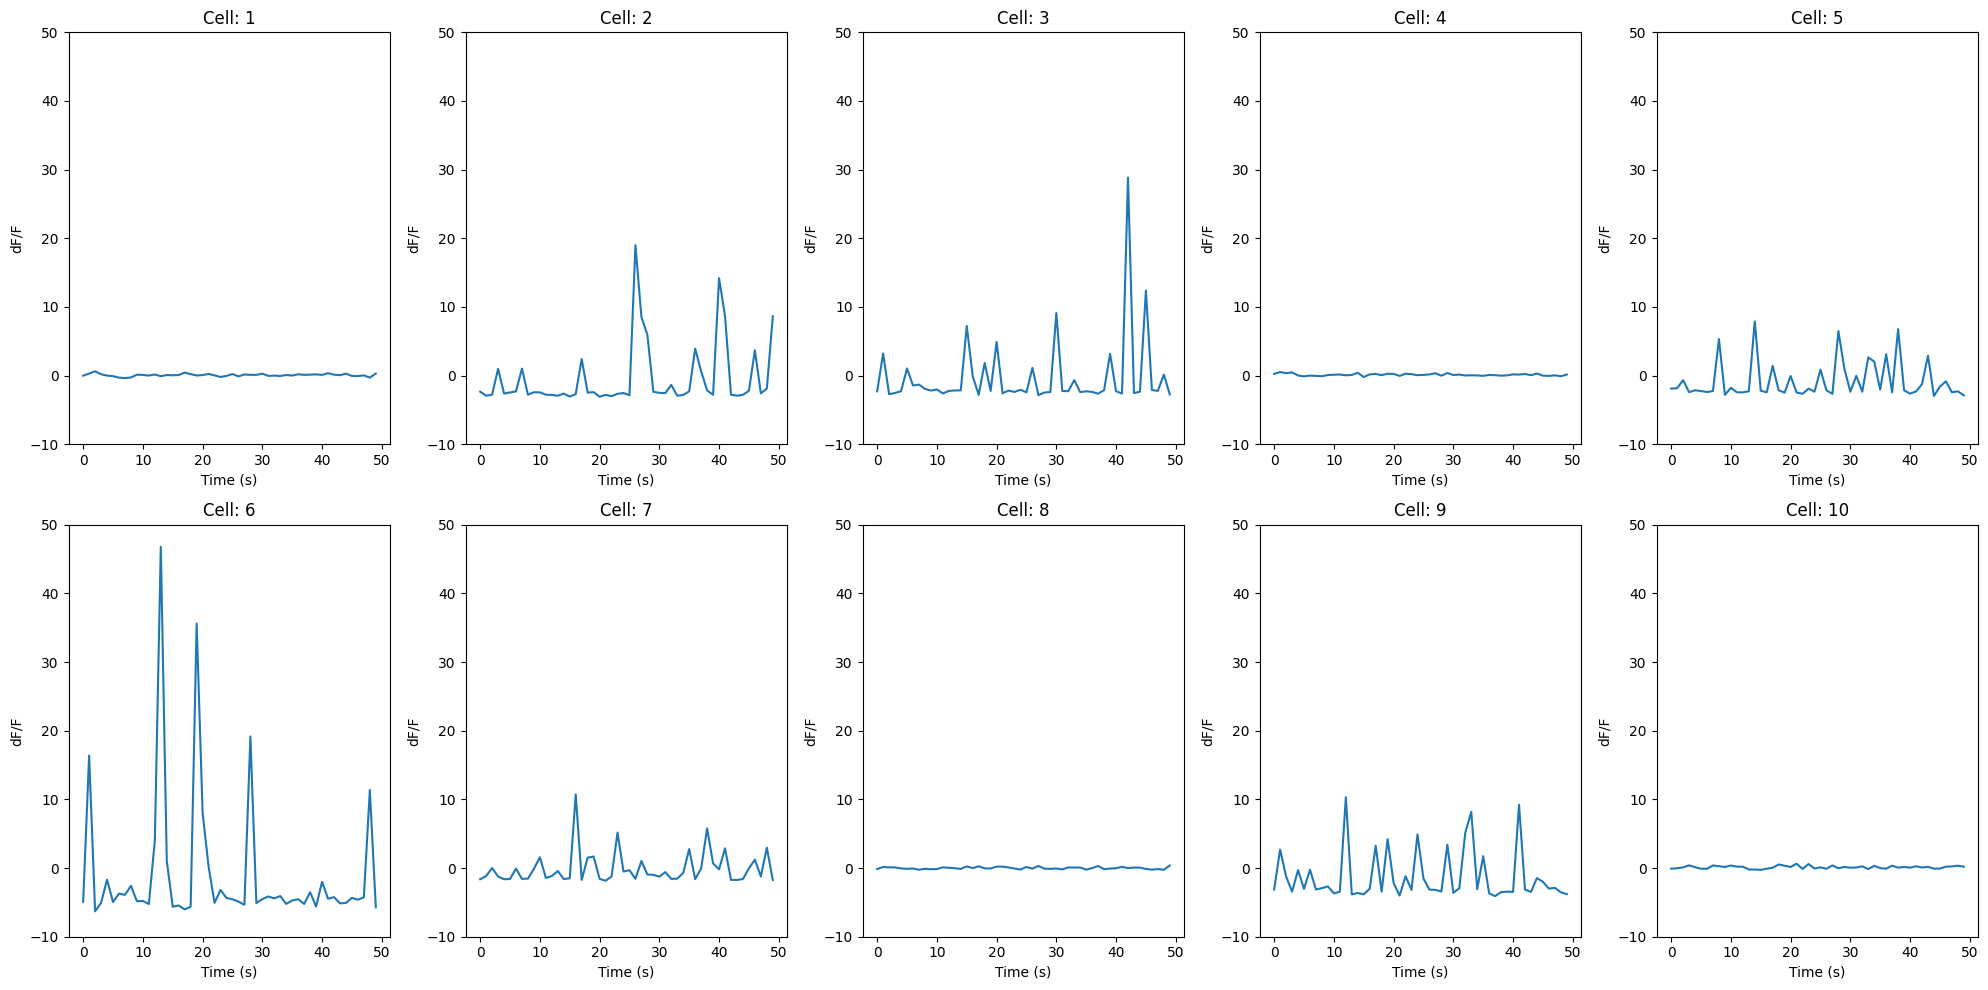

In [5]:
## plot the spiking of subset of cells
## define function to plot spikes
def plot_spikes_subset(spks_cell, time_points=50):
    # np.random.seed(100)
    # someCells = np.random.choice(NUM_CELLS, 10) ## select 10 random cells
    someCells = np.arange(10)
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(10):
        axes[i].plot(spks_cell[i, :time_points])
        axes[i].set_title("Cell: " + str(someCells[i] + 1))
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("dF/F")
        axes[i].set_ylim(-10, 50)

    plt.tight_layout()
    plt.show()

plot_spikes_subset(dF_F)

### Subset data according to the length of recording 

In [9]:
## define a function to subset the data 
def subset_data(data, num_points):
    num_cells = data.shape[0]
    data_subset = np.zeros((num_cells, num_points))

    for i in range(num_cells):
        data_subset[i] = data[i][:num_points]

    return data_subset

In [10]:
data_subset = {}

time_keys = [10, 15, 20, 30, 40, 45] ## this is in minutes 
print(type(time_keys[0]))
for time in time_keys:
    if time != 45:
        data_subset[time] = subset_data(dF_F, int(time*FRAME_RATE*60))
    else:
        data_subset[time] = dF_F 

## check the shape of the data
for time in data_subset.keys():
    print(f"The shape of the data for time {time} is {data_subset[time].shape}")

<class 'int'>
The shape of the data for time 10 is (58, 9294)
The shape of the data for time 15 is (58, 13941)
The shape of the data for time 20 is (58, 18588)
The shape of the data for time 30 is (58, 27882)
The shape of the data for time 40 is (58, 37176)
The shape of the data for time 45 is (58, 41823)


### Functional Connectivity using Pearson's correlation for all lengths

### Calculate correlation matrices

In [11]:
## calculate the correlation matrix for each time point
correlation_matrices = {}
for time in time_keys:
    correlation_matrices[time] = np.corrcoef(data_subset[time])

    ## remove autocorrelation i.e. the diagonal elements
    np.fill_diagonal(correlation_matrices[time], 0)

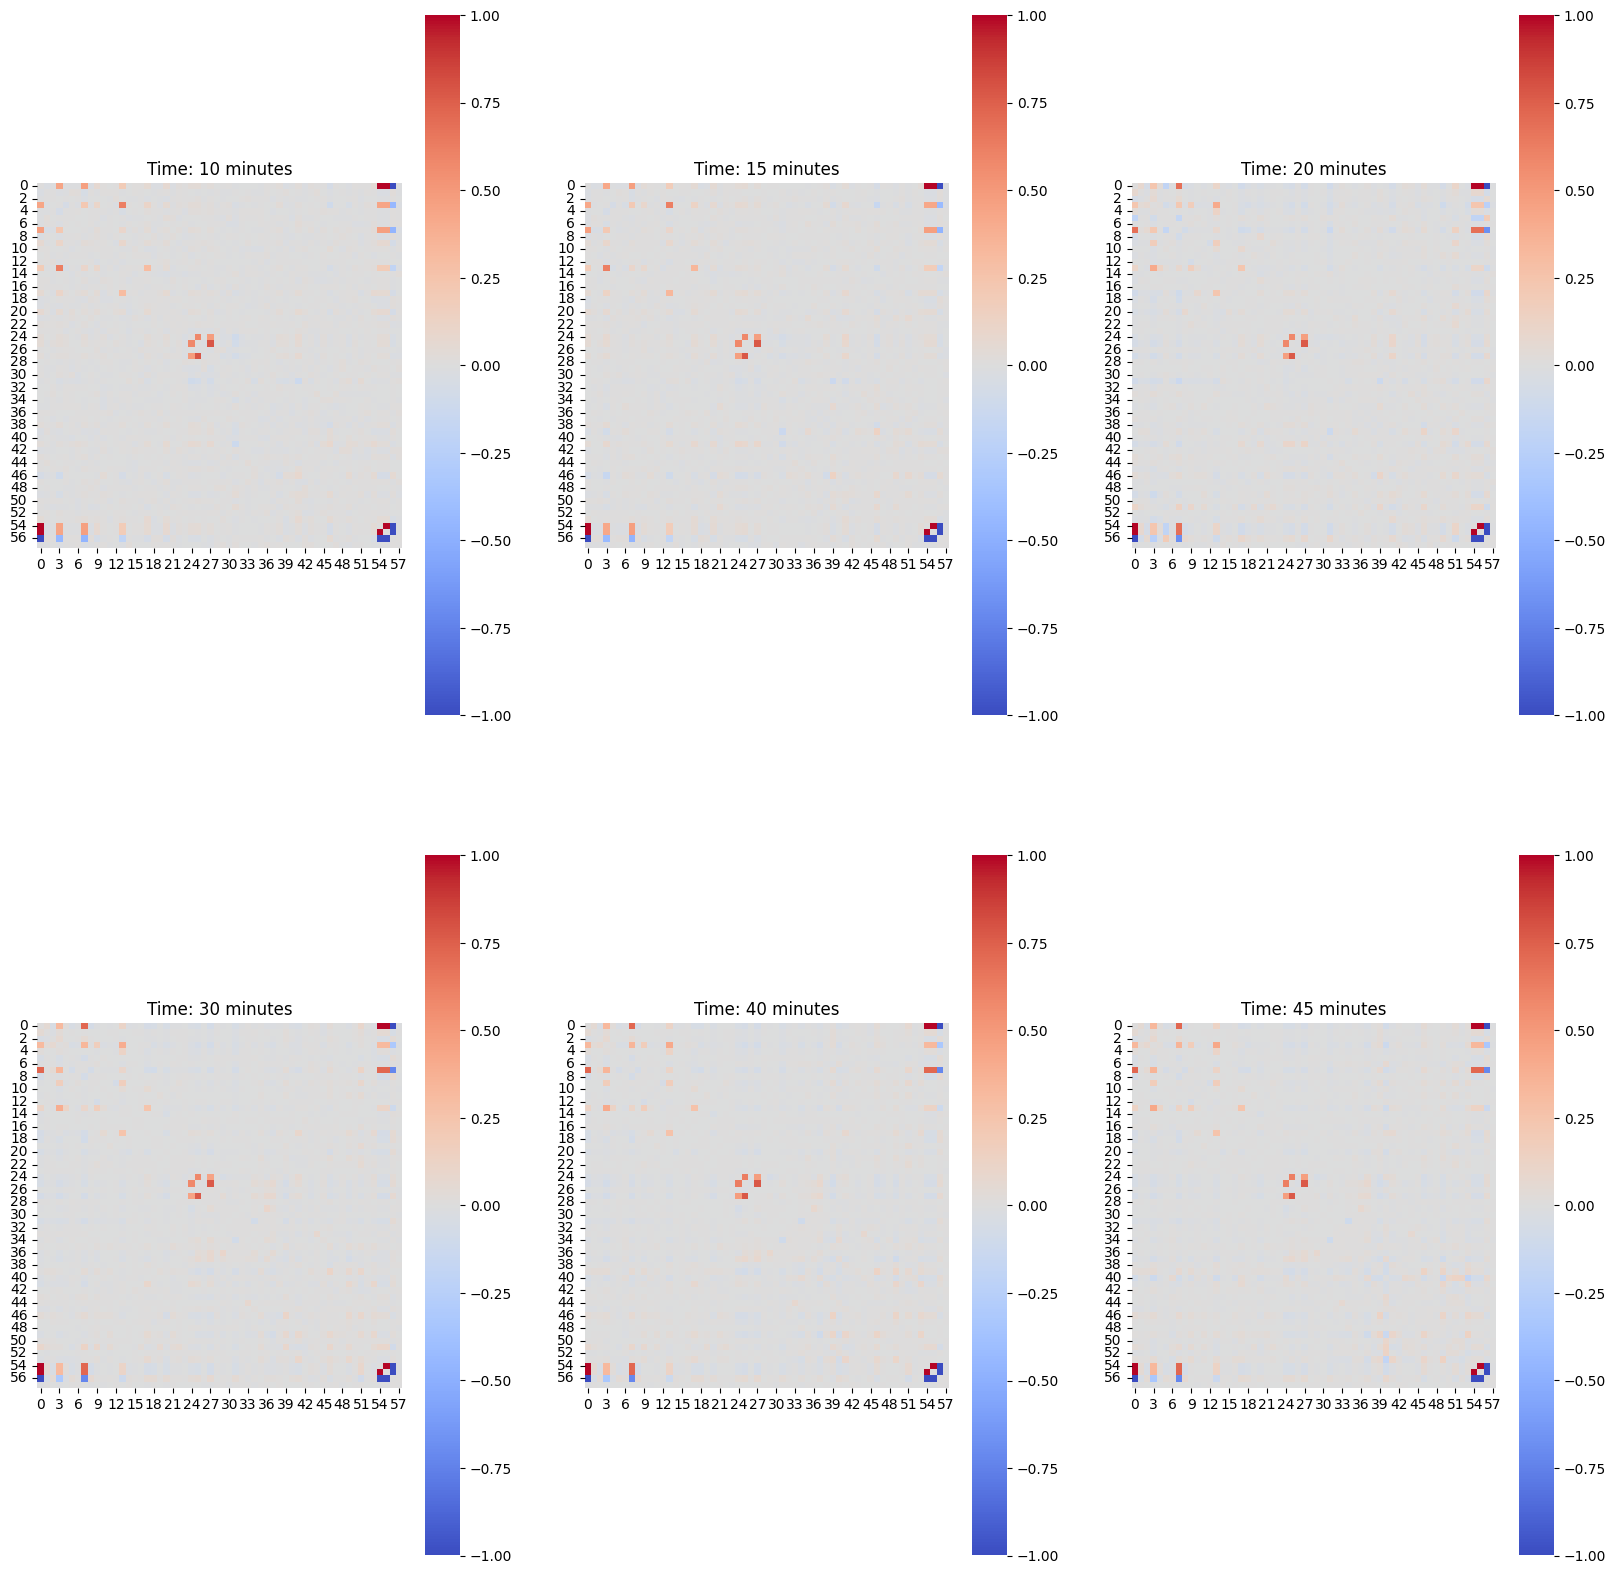

In [13]:
## plot the correlation matrix for each time point
## make the plot square 
num_rows = int(len(time_keys) // np.sqrt(len(time_keys)))
num_cols = int(len(time_keys) // num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

## create clustered heatmap for each time point
for time in time_keys:
    sns.heatmap(correlation_matrices[time], ax=axes[time_keys.index(time)], cmap="coolwarm", square=True)
    axes[time_keys.index(time)].set_title(f"Time: {time} minutes")

plt.show()

### Assessing the similarity of the correlation matrices

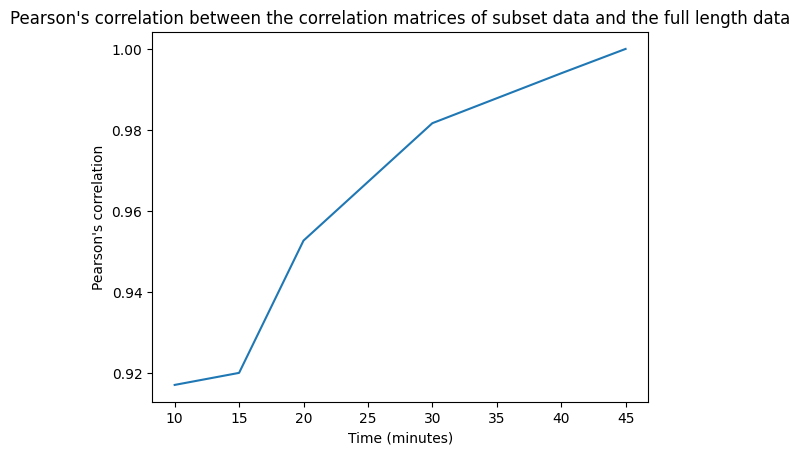

In [14]:
## Measuring the Pearson's correlation between the correlation matrices of subset data and the full length data
corr_time = {}

for time in time_keys:
    ref_corr = correlation_matrices[45]
    subset_corr = correlation_matrices[time]
    correlation = np.corrcoef(ref_corr.flatten(), subset_corr.flatten())
    corr_time[(time, 45)] = correlation[0, 1]
    # print(f"The Pearson's correlation between the correlation matrices of 45 minutes and {time} minutes is {correlation[0, 1]}")

## plot the correlation between the correlation matrices of the subset data and the full length data
time = [time[0] for time in corr_time.keys()]
correlation = [corr_time[time] for time in corr_time.keys()]

plt.plot(time, correlation)
plt.xlabel("Time (minutes)")
plt.ylabel("Pearson's correlation")
plt.title("Pearson's correlation between the correlation matrices of subset data and the full length data")
plt.show()

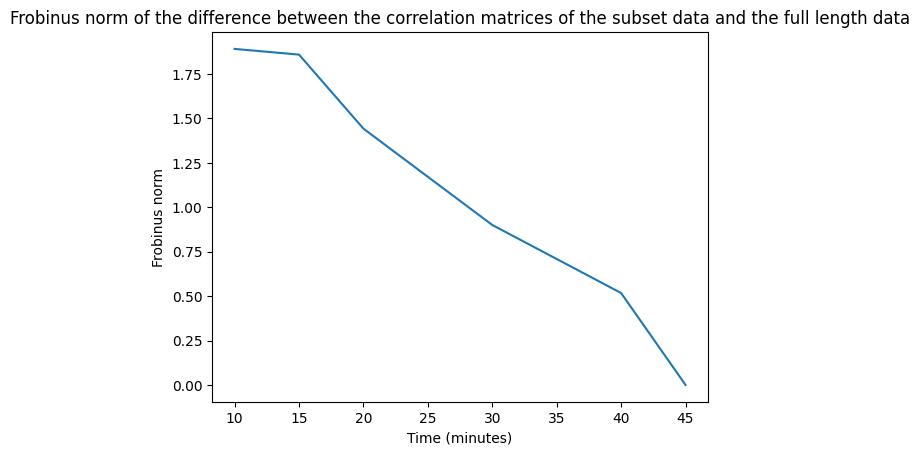

In [15]:
## computing the Frobinus norm of the difference between the correlation matrices of the subset data and the full length data
frobinus_norm = {}

for time in time_keys:
    ref_corr = correlation_matrices[45]
    subset_corr = correlation_matrices[time]
    frobinus_norm[(time, 45)] = np.linalg.norm(ref_corr - subset_corr)

## plot the Frobinus norm of the difference between the correlation matrices of the subset data and the full length data
time = [time[0] for time in frobinus_norm.keys()]
frobinus = [frobinus_norm[time] for time in frobinus_norm.keys()]

plt.plot(time, frobinus)
plt.xlabel("Time (minutes)")
plt.ylabel("Frobinus norm")
plt.title("Frobinus norm of the difference between the correlation matrices of the subset data and the full length data")
plt.show()

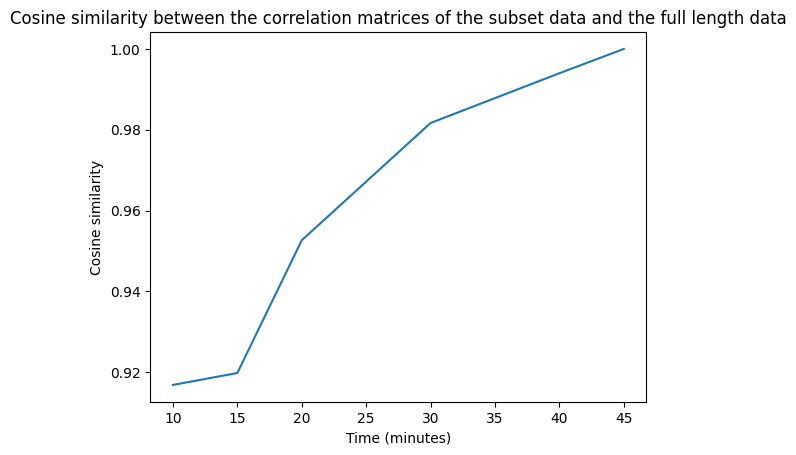

In [16]:
## calulating the cosine similarity between the correlation matrices of the subset data and the full length data
cosine_similarity = {}

for time in time_keys:
    ref_corr = correlation_matrices[45]
    subset_corr = correlation_matrices[time]
    cosine_similarity[(time, 45)] = np.dot(ref_corr.flatten(), subset_corr.flatten()) / (np.linalg.norm(ref_corr) * np.linalg.norm(subset_corr))

## plot the cosine similarity between the correlation matrices of the subset data and the full length data
time = [time[0] for time in cosine_similarity.keys()]
cosine = [cosine_similarity[time] for time in cosine_similarity.keys()]

plt.plot(time, cosine)
plt.xlabel("Time (minutes)")
plt.ylabel("Cosine similarity")
plt.title("Cosine similarity between the correlation matrices of the subset data and the full length data")
plt.show()